# Clustering - identifying groups of countries with similar profiles
---

## Introduction

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

pd.options.display.max_columns = 50

import warnings
warnings.filterwarnings("ignore")

In [2]:
from pyspark.sql import SparkSession

from pyspark.sql.functions import *
#from pyspark.sql.functions import lit, col
from pyspark.sql.types import DoubleType

## 1. Data preparation

Let's see what our dataset looks like

In [3]:
# creation of a spark session
spk_sess = SparkSession \
    .builder \
    .appName("_Project_Spark_App") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

# load csv file in a DF and show first lines
df = spk_sess.read.csv("./solar_generation_by_country.csv", header=True, sep=",");

__Understanding of the dataset__

In [4]:
# Print the schema of df
df.explain()

# Print the (logical and physical) plans
df.printSchema 

== Physical Plan ==
*(1) FileScan csv [AT#10,BE#11,BG#12,CH#13,CY#14,CZ#15,DE#16,DK#17,EE#18,ES#19,FI#20,FR#21,EL#22,HR#23,HU#24,IE#25,IT#26,LT#27,LU#28,LV#29,NL#30,NO#31,PL#32,PT#33,... 5 more fields] Batched: false, Format: CSV, Location: InMemoryFileIndex[file:/home/jovyan/work/solar_generation_by_country.csv], PartitionFilters: [], PushedFilters: [], ReadSchema: struct<AT:string,BE:string,BG:string,CH:string,CY:string,CZ:string,DE:string,DK:string,EE:string,...


<bound method DataFrame.printSchema of DataFrame[AT: string, BE: string, BG: string, CH: string, CY: string, CZ: string, DE: string, DK: string, EE: string, ES: string, FI: string, FR: string, EL: string, HR: string, HU: string, IE: string, IT: string, LT: string, LU: string, LV: string, NL: string, NO: string, PL: string, PT: string, RO: string, SI: string, SK: string, SE: string, UK: string]>

In [5]:
print(df.columns)
# df.dtypes

['AT', 'BE', 'BG', 'CH', 'CY', 'CZ', 'DE', 'DK', 'EE', 'ES', 'FI', 'FR', 'EL', 'HR', 'HU', 'IE', 'IT', 'LT', 'LU', 'LV', 'NL', 'NO', 'PL', 'PT', 'RO', 'SI', 'SK', 'SE', 'UK']


__Changing columns' types__

In [6]:
# change cols types
for c in df.columns:
    if c != 'date_time':
        df = df.withColumn(c, df[c].cast(DoubleType()))
        
df.printSchema()
# same info retrieved with df.dtypes

root
 |-- AT: double (nullable = true)
 |-- BE: double (nullable = true)
 |-- BG: double (nullable = true)
 |-- CH: double (nullable = true)
 |-- CY: double (nullable = true)
 |-- CZ: double (nullable = true)
 |-- DE: double (nullable = true)
 |-- DK: double (nullable = true)
 |-- EE: double (nullable = true)
 |-- ES: double (nullable = true)
 |-- FI: double (nullable = true)
 |-- FR: double (nullable = true)
 |-- EL: double (nullable = true)
 |-- HR: double (nullable = true)
 |-- HU: double (nullable = true)
 |-- IE: double (nullable = true)
 |-- IT: double (nullable = true)
 |-- LT: double (nullable = true)
 |-- LU: double (nullable = true)
 |-- LV: double (nullable = true)
 |-- NL: double (nullable = true)
 |-- NO: double (nullable = true)
 |-- PL: double (nullable = true)
 |-- PT: double (nullable = true)
 |-- RO: double (nullable = true)
 |-- SI: double (nullable = true)
 |-- SK: double (nullable = true)
 |-- SE: double (nullable = true)
 |-- UK: double (nullable = true)



__First insight__

In [7]:
df.select('FR', 'UK', 'ES').show(15)

+-------------------+-------------------+-------------------+
|                 FR|                 UK|                 ES|
+-------------------+-------------------+-------------------+
|                0.0|                0.0|                0.0|
|                0.0|                0.0|                0.0|
|                0.0|                0.0|                0.0|
|                0.0|                0.0|                0.0|
|                0.0|                0.0|                0.0|
|                0.0|                0.0|                0.0|
|                0.0|                0.0|                0.0|
|                0.0|                0.0|                0.0|
| 0.0420031786189225|                0.0| 0.0439209623544281|
|  0.123842705213728| 0.0474854446145074|0.14601200686106303|
|  0.158755711424721|0.10951678628072099|0.20926243567752997|
|  0.198553152005591|  0.164216422322982|0.24708337149661103|
|  0.201228475964132|  0.155820023810148|0.28553508719719106|
|  0.183

__Shape of the dataframe__

In [8]:
df.count(), len(df.columns)

(262968, 29)

In [9]:
# Count the number of distinct rows in df
df.distinct().count()

158709

__Missing values__

In the case of NaNs, here is a usefull link to [deal with missing values](https://fr.coursera.org/lecture/big-data-machine-learning/handling-missing-values-in-spark-Goh1z). But here, there isn't any missing values :

In [10]:
#from pyspark.sql.functions import isnan, when, count, col
df.select([count(when(isnan(c), c)).alias(c) for c in df.columns if c != 'date_time']).show()
# drop na values if needed / not the case here -> df = df.na.drop()

+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+
| AT| BE| BG| CH| CY| CZ| DE| DK| EE| ES| FI| FR| EL| HR| HU| IE| IT| LT| LU| LV| NL| NO| PL| PT| RO| SI| SK| SE| UK|
+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+
|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|
+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+



__Transpose our dataframe__

Because clusters are made from rows, the countries should be seen horizontally. So we need to transpose our dataframe, which is, as far as i know not possible with Spark. Because Spark DataFrame distributes data by row (although locally uses columnar storage). Therefore size of a individual rows is limited to local memory. 

An option is to convert it to Pandas DataFrame if data is small enough to be transposed (not pivoted with aggregation) or to use and RDD.

Sources : 
- https://stackoverflow.com/questions/46453058/dataframe-transpose-with-pyspark-in-apache-spark
- https://community.cloudera.com/t5/Support-Questions/How-to-transpose-a-pyspark-dataframe/td-p/131471
- http://www.data-intuitive.com/2015/01/transposing-a-spark-rdd/

In [11]:
rdd = df.rdd
rdd.take(3)

def rddTranspose(_rdd):
    _rddT1 = _rdd.zipWithIndex().flatMap(lambda x, i: [(i, j, e) for (j, e) in enumerate(x)])
    _rddT2 = _rddT1.map(lambda i, j, e: (j, (i,e))).groupByKey().sortByKey()
    _rddT3 = _rddT2.map(lambda i, x: sorted(list(x), cmp=lambda i1,e1,i2,e2 : cmp(i1, i2)))
    _rddT4 = _rddT3.map(lambda x: map(lambda i, y: y, x))
    return _rddT4.map(lambda x: np.asarray(x))

#rddTranspose(rdd)

In [12]:
# create a temporary pandas df, keep one year and transpose it, 
# reset index in order to create a col with countries' names
temp_df = df.toPandas()[-24*365:].T
temp_df = temp_df.reset_index()
temp_df.head()

,index,254208,254209,254210,254211,254212,254213,254214,254215,254216,254217,254218,254219,254220,254221,254222,254223,254224,254225,254226,254227,254228,254229,254230,254231,...,262943,262944,262945,262946,262947,262948,262949,262950,262951,262952,262953,262954,262955,262956,262957,262958,262959,262960,262961,262962,262963,262964,262965,262966,262967
0,AT,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.027972,0.113287,0.127273,0.116084,0.113287,0.109091,0.099301,0.064336,0.020979,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.040559,0.282517,0.405594,0.460140,0.474126,0.433566,0.358042,0.209790,0.018182,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,BE,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.019710,0.232778,0.392154,0.456041,0.442448,0.302101,0.183844,0.029225,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.045196,0.251128,0.356473,0.433952,0.459439,0.404048,0.267779,0.075101,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,BG,0.0,0.0,0.0,0.0,0.0,0.0,0.035793,0.192023,0.302919,0.354551,0.382422,0.369163,0.313377,0.225553,0.065662,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.03475,0.202214,0.342270,0.452312,0.463855,0.464995,0.398385,0.297605,0.111154,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,CH,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.014463,0.107674,0.163776,0.185244,0.186777,0.181647,0.175124,0.141796,0.053878,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.016734,0.047136,0.075455,0.116825,0.126402,0.127811,0.102086,0.085494,0.058601,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,CY,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
# Create a Spark DataFrame from the pandas DataFrame with only 1 year
df = spk_sess.createDataFrame(temp_df)
del temp_df
df.count(), len(df.columns)

(29, 8761)

__Assemble our features__

Source : https://stackoverflow.com/questions/47585723/kmeans-clustering-in-pyspark

In contrast to most ML packages out there, Spark ML requires your input features to be gathered in a single column of your dataframe, usually named features; and it provides a specific method for doing this, VectorAssembler:

In [14]:
from pyspark.ml.feature import VectorAssembler

vec_assembler = VectorAssembler(inputCols=[c for c in df.columns if c is not 'index'], outputCol="features")
df = vec_assembler.transform(df)
df.select('index', 'features').show(15)

+-----+--------------------+
|index|            features|
+-----+--------------------+
|   AT|(8760,[7,8,9,10,1...|
|   BE|(8760,[8,9,10,11,...|
|   BG|(8760,[6,7,8,9,10...|
|   CH|(8760,[7,8,9,10,1...|
|   CY|        (8760,[],[])|
|   CZ|(8760,[7,8,9,10,1...|
|   DE|(8760,[7,8,9,10,1...|
|   DK|(8760,[8,9,10,11,...|
|   EE|(8760,[7,8,9,10,1...|
|   ES|(8760,[8,9,10,11,...|
|   FI|(8760,[8,9,10,11,...|
|   FR|(8760,[8,9,10,11,...|
|   EL|(8760,[6,7,8,9,10...|
|   HR|(8760,[7,8,9,10,1...|
|   HU|(8760,[7,8,9,10,1...|
+-----+--------------------+
only showing top 15 rows



As perhaps already guessed, the argument inputCols serves to tell VectoeAssembler which particular columns in our dataframe are to be used as features.

---

## 2. Clustering

__About K-Means__

K-Means clustering is one of the simplest and popular unsupervised machine learning algorithms. The goal of this algorithm is to find groups in the data, with the number of groups/clusters represented by the variable K. K-Means algorithm iteratively allocates every data point to the nearest cluster based on the features. In every iteration of the algorithm, each data point is assigned to its nearest cluster based on some distance metric, which is usually Euclidean distance. The outputs of the K-means clustering algorithm are the centroids of K clusters and the labels of training data. Once the algorithm runs and identified the groups from a data set, any new data can be easily assigned to a group.

K-Means algorithm can be used to identifies unknown groups in complex and unlabeled data sets.

source : https://medium.com/rahasak/k-means-clustering-with-apache-spark-cab44aef0a16m

__What's the optimal nb of clusters__

The Elbow Method is one of the most popular methods to determine this optimal value of k groups into which the data may be clustered. 
To determine the optimal number of clusters, we have to select the value of k at the “elbow” ie the point after which the cost (equivalent to sklearn's inertia) start decreasing in a linear fashion. Thus for the given data, we conclude that the optimal number of clusters for the data is

Text(0, 0.5, 'cost')

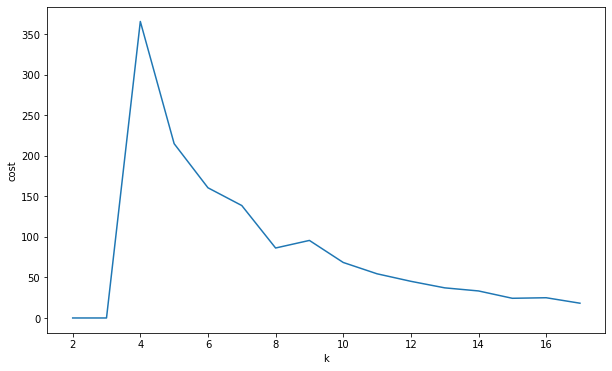

In [21]:
from pyspark.ml.clustering import KMeans

max_nb_cl = 18

cost = np.zeros(max_nb_cl)
for k in range(4, max_nb_cl):
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
    model = kmeans.fit(df)
    cost[k] = model.computeCost(df) / k  # requires Spark 2.0 or later

    
fig, ax = plt.subplots(1,1, figsize =(10, 6))
ax.plot(range(2, max_nb_cl),cost[2:max_nb_cl])
ax.set_xlabel('k')
ax.set_ylabel('cost')

The computerCost method will be depreciated soon, use ClusteringEvaluator instead.

__Rebuild & fit our KMeans model with the optimal value of k__

Next we can build K-Means model by defining no of clusters, feature column and output prediction column.

In [16]:
kmeans = KMeans(k=6, seed=1)                 # 6 clusters here
model = kmeans.fit(df.select('features'))

select('features') here serves to tell the algorithm which column of the dataframe to use for clustering - remember that, after Step 1 above, your original lat & long features are no more directly used.

__Transform our initial dataframe to include cluster assignments__



In [17]:
transformed = model.transform(df)
transformed.select('index', 'features', 'prediction').show(15) 

+-----+--------------------+----------+
|index|            features|prediction|
+-----+--------------------+----------+
|   AT|(8760,[7,8,9,10,1...|         4|
|   BE|(8760,[8,9,10,11,...|         2|
|   BG|(8760,[6,7,8,9,10...|         3|
|   CH|(8760,[7,8,9,10,1...|         2|
|   CY|        (8760,[],[])|         0|
|   CZ|(8760,[7,8,9,10,1...|         4|
|   DE|(8760,[7,8,9,10,1...|         2|
|   DK|(8760,[8,9,10,11,...|         1|
|   EE|(8760,[7,8,9,10,1...|         1|
|   ES|(8760,[8,9,10,11,...|         5|
|   FI|(8760,[8,9,10,11,...|         1|
|   FR|(8760,[8,9,10,11,...|         2|
|   EL|(8760,[6,7,8,9,10...|         3|
|   HR|(8760,[7,8,9,10,1...|         4|
|   HU|(8760,[7,8,9,10,1...|         4|
+-----+--------------------+----------+
only showing top 15 rows



The last column of the transformed dataframe, prediction, shows the cluster assignment. I have ended up with much more records in cluster 0 see below.

One can further manipulate the transformed dataframe with select statements, or even drop the features column (which has now fulfilled its function and may be no longer necessary)...

In [18]:
# count the number of records for each distinct value
transformed.groupBy("prediction").count().orderBy("prediction").show()

# only unique values -> transformed.select("prediction").distinct().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         0|    4|
|         1|    6|
|         2|    7|
|         3|    3|
|         4|    7|
|         5|    2|
+----------+-----+



Let's see what each cluster of countryies is made of : 

In [19]:
from pyspark.sql import functions as F

transformed.groupby("prediction").agg(F.collect_set("index")).orderBy("prediction").show(30)

+----------+--------------------+
|prediction|  collect_set(index)|
+----------+--------------------+
|         0|    [CY, NO, UK, IE]|
|         1|[LT, FI, DK, EE, ...|
|         2|[BE, NL, IT, CH, ...|
|         3|        [EL, BG, RO]|
|         4|[PL, AT, SI, HR, ...|
|         5|            [ES, PT]|
+----------+--------------------+



__Save K-Means model__

The built model can be persisted in to disk in order to use later. For an example use with spark streams application to detect the clusters of realtime uber trips.

In [20]:
# save model
#model.save("kmeans_model")

# load model (if necessary)
#model = KMeans().load("kmeans_model")

__Clusters statistics__

source : https://stackoverflow.com/questions/47130299/pyspark-ml-get-kmeans-cluster-statistics/47156822#47156822

another interesting ressources : https://rsandstroem.github.io/sparkkmeans.html & https://runawayhorse001.github.io/LearningApacheSpark/clustering.html

(Py)Spark ML is indeed much more limited that scikit-learn or other similar packages, and such functionality is not trivial; nevertheless, the links above provide a way to get cluster statistics.

réf :
- https://databricks-prod-cloudfront.cloud.databricks.com/public/4027ec902e239c93eaaa8714f173bcfc/1101947090054953/2232878890938999/6387199866535941/latest.html
- https://stackoverflow.com/questions/56371503/pyspark-how-to-find-appropriate-number-of-clusters